##### Project 2 - Big-Scale Analysis 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [5]:
# A disaster tweet
disaster_tweet = train[train['Target'] == 1]['Tweet text']
disaster_tweet.values[1]

'#ISIS claims responsibility for Saudi suicide bombing  http://t.co/jlMICJ6jE5'

In [6]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['Target'] == 0]['Tweet text']
non_disaster_tweet.values[1]

'Building Muscle With Feast And Famine Feeding Most diet plans are based around losing weight but what should you\x89Û_ https://t.co/lUe3waeGpI'

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries

In [1]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alixm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# II. EDA

## 1. Training set

### Data loading

In [2]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

In [3]:
train.columns = ['ID', 'Keyword', 'Location', 'Tweet text', 'Target']
train.head()

,ID,Keyword,Location,Tweet text,Target
6412,9169,suicide%20bomber,Indonesia,Suicide bomber kills 15 in Saudi security site...,1
4710,6697,landslide,NaN,@Morning_Joe @Reince @PressSec Joe ur so smart...,0
3553,5078,famine,"Edappally,Kochi",Building Muscle With Feast And Famine Feeding ...,0
6401,9148,suicide%20bomber,NaN,#ISIS claims responsibility for Saudi suicide ...,1
1698,2453,collide,"Dallas, Texas.",You either ride with us or collide with us. It...,0


### Distribution of the target column

In [4]:
#when the target = 1 it means the the tweet is about a disaster
train_yes = train.query('Target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters (Target = 0).')

#when the target = 0 it means the the tweet is not about a disaster
train_no = train.query('Target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters (Target = 1).')

There are 3271 tweets about disasters (Target = 0).
There are 4342 tweets that are not about disasters (Target = 1).


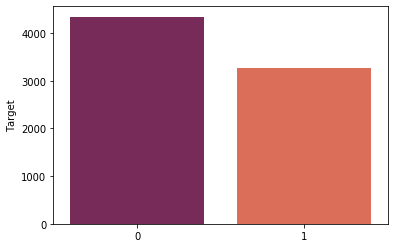

In [7]:
sns.barplot(train['Target'].value_counts().index, train['Target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

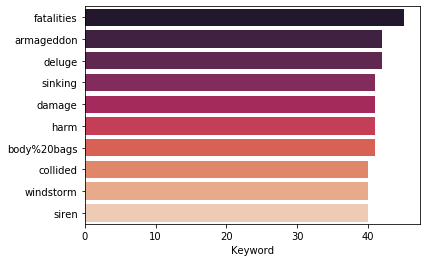

In [8]:
sns.barplot(y = train['Keyword'].value_counts()[:10].index, x = train['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [9]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

1    102
0     40
Name: Target, dtype: int64

## 2. Test set

### Data loading

In [10]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

(3263, 4)

In [11]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

,ID,Keyword,Location,Tweet text
817,2686,crush,NaN,@sandy0013 dude i have a crush on hockey playe...
1994,6718,lava,"Missouri, USA",PSA: MISTI IS ABOUT TO MAKE LAVA CAKE???? #bes...
1943,6557,injury,www.dorsavi.com,Supermarket chains recording worst #injury rat...
664,2166,catastrophic,NaN,[WP] Following a catastrophic event the United...
1902,6424,hurricane,Hawaii,HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...


### Distribution of the Keyword column

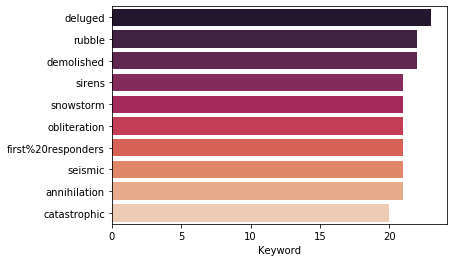

In [12]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [13]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

6412    suicide bomber kills  in saudi security site m...
4710    morningjoe reince presssec joe ur so smart u s...
3553    building muscle with feast and famine feeding ...
6401    isis claims responsibility for saudi suicide b...
1698    you either ride with us or collide with us its...
Name: Tweet text, dtype: object

In [14]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

817      dude i have a crush on hockey players but pau...
1994      psa misti is about to make lava cake bestdayeva
1943    supermarket chains recording worst injury rate...
664      following a catastrophic event the united sta...
1902    hurricane guillermo live noaa tracking  loopin...
Name: Tweet text, dtype: object

In [15]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

6412    [suicide, bomber, kills, in, saudi, security, ...
4710    [morningjoe, reince, presssec, joe, ur, so, sm...
3553    [building, muscle, with, feast, and, famine, f...
6401    [isis, claims, responsibility, for, saudi, sui...
1698    [you, either, ride, with, us, or, collide, wit...
Name: Tweet text, dtype: object

In [16]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

817     [dude, i, have, a, crush, on, hockey, players,...
1994    [psa, misti, is, about, to, make, lava, cake, ...
1943    [supermarket, chains, recording, worst, injury...
664     [following, a, catastrophic, event, the, unite...
1902    [hurricane, guillermo, live, noaa, tracking, l...
Name: Tweet text, dtype: object

In [17]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

6412    [suicide, bomber, kills, saudi, security, site...
4710    [morningjoe, reince, presssec, joe, ur, smart,...
3553    [building, muscle, feast, famine, feeding, die...
6401    [isis, claims, responsibility, saudi, suicide,...
1698      [either, ride, us, collide, us, simple, niggas]
Name: Tweet text, dtype: object

In [18]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

817     [dude, crush, hockey, players, paul, always, g...
1994           [psa, misti, make, lava, cake, bestdayeva]
1943    [supermarket, chains, recording, worst, injury...
664     [following, catastrophic, event, united, state...
1902    [hurricane, guillermo, live, noaa, tracking, l...
Name: Tweet text, dtype: object

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [20]:
from sklearn.model_selection import train_test_split

X = train['Tweet text']
ylabels = train['Target']


print('X shape: ', X.shape)
print('y shape: ', ylabels.shape)
X.head()

X shape:  (7613,)
y shape:  (7613,)


6412    [suicide, bomber, kills, saudi, security, site...
4710    [morningjoe, reince, presssec, joe, ur, smart,...
3553    [building, muscle, feast, famine, feeding, die...
6401    [isis, claims, responsibility, saudi, suicide,...
1698      [either, ride, us, collide, us, simple, niggas]
Name: Tweet text, dtype: object

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['Tweet text'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['Tweet text'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['Target']

X_train.shape

(7613, 16222)

In [22]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

clf = BernoulliNB()
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.7994211855945942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

scores = cross_val_score(knn, X_train, y_train)
print(scores.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.678706256760584
